In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chembl22/chembl_22_clean_1576904_sorted_std_final.smi


**Importing Libraries**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from concurrent.futures import ThreadPoolExecutor
from keras.models import Model
from keras.layers import TextVectorization
from keras.layers import Input, Embedding, LSTM, GRU, Dense
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

**Reading Data**

In [3]:
with open("/kaggle/input/chembl22/chembl_22_clean_1576904_sorted_std_final.smi") as file_handle:
    data = file_handle.readlines()

In [4]:
data = data[0:1000]

**Extracting Module**

In [5]:
def return_molecule(molecule):
    return molecule.split("\t")[0]

In [6]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data = list(pool.map(return_molecule, data))

In [7]:
max_length=len(max(data, key=len))
print(f"Maximum length molecule is: {max_length}")

Maximum length molecule is: 13


Text(0, 0.5, 'Frequency')

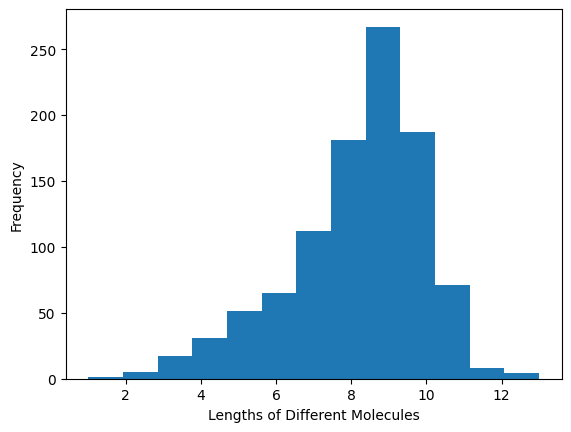

In [8]:
import matplotlib.pyplot as plt
len_mole=[]
for mole in data:
    len_mole.append(len(mole))
plt.hist(x=len_mole, bins=len(set(len_mole)))
plt.xlabel("Lengths of Different Molecules")
plt.ylabel("Frequency")

**Filtering Data**

In [9]:
max_length_molecule=52
new_data=[]
for mole in data:
    if len(mole)<=max_length_molecule:
        new_data.append(mole)
print(f"The size of the new_data is : {len(new_data)}")

The size of the new_data is : 1000


In [10]:
max_seq_length=len(max(new_data, key=len))
max_seq_length


13

**Adding Tokens**

Adding the tokens that represents the start of the molecule(<) and end of the molecule(>)

In [11]:
def adding_tokens(text):
    return "<"+text+">"

In [12]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    new_data = list(pool.map(adding_tokens, new_data))

#### We'll divide the molecule in two parts i.e. input data and output data
For eg: **< CCO >** -> input data **< CCO** and output data **CCO>**


Our input data (that will go into decoder) will contain only the starting token (<) and our output data (that decoder generates) will contain the ending token(>)

**Making Input Data**

In [13]:
def convert_to_source_str(molecule):
    return molecule.strip(">")

In [14]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    X=list(pool.map(convert_to_source_str,new_data))

**Making Output data**

In [15]:
def convert_to_source_str(molecule_str):
    return molecule_str.strip("<")

In [16]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    Y = list(pool.map(convert_to_source_str,new_data))

In [17]:
list_of_tuples = list(zip(X, Y))

In [18]:
molecule_file=pd.DataFrame(list_of_tuples,columns=["X", 'Y'])


In [19]:
molecule_file

,X,Y
0,<CCO,CCO>
1,<C,C>
2,<CO,CO>
3,<NCCS,NCCS>
4,<NCCN,NCCN>
...,...,...
995,<CN1CCSC1=S,CN1CCSC1=S>
996,<CCCCC=CC=O,CCCCC=CC=O>
997,<BrCC=CCBr,BrCC=CCBr>
998,<N#CC=CC#N,N#CC=CC#N>


**Vocabulary**

In [20]:
vocabulary=set("".join(new_data))

In [21]:
vocabulary=list(vocabulary)
len_vocabulary=len(vocabulary)
print(f"The length of the list is :{len_vocabulary}")

The length of the list is :26


#### Determining the maximum sequence length 

molecule_file["X"] and molecule_file["Y"] will have same sequence length because they possess the same molecule and both of them have one extra token either(<) or (>)

In [22]:
max_seq_len = len(max(molecule_file["X"], key=len))
print(f"The maximum sequence length : {max_seq_len}")

The maximum sequence length : 14


**TextVectorization**

In [23]:
tv_layer = TextVectorization( max_tokens=len_vocabulary+2,
    standardize=None,
    split='character',
    ngrams=None,
    output_mode='int',
    output_sequence_length=max_seq_len,
    pad_to_max_tokens=False,
    vocabulary=vocabulary,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',)

In [24]:
vectorized_data=tv_layer(data)
vectorized_train=tv_layer(molecule_file["X"])
vectorized_test=tv_layer(molecule_file["Y"])

In [25]:
max_input_sequence_length = len(max(list(molecule_file["X"]), key=len))
max_output_sequence_length = len(max(list(molecule_file["Y"]), key=len))
max_seq_data_length = len(max(list(new_data), key=len))

print(f"maximum sequence length for input in decoder: { max_input_sequence_length}")
print(f"maximum sequence length for output in decoder: { max_output_sequence_length}")
print(f"maximum sequence length for input in encoder: {max_seq_data_length}")

maximum sequence length for input in decoder: 14
maximum sequence length for output in decoder: 14
maximum sequence length for input in encoder: 15


In [26]:
neuron_units=40
embedding_layer_output=60

In [27]:
vectorized_test_one_hot = to_categorical(vectorized_test, num_classes=len_vocabulary+2)

In [28]:
print(f"one hot encoded output data: {vectorized_test_one_hot[0][0].shape}")

one hot encoded output data: (28,)


In [29]:
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

# Input to the encoder
enc_input = Input(shape=(None,), name="input_to_encoder")

# Embedding layer for the encoder
enc_embedding = Embedding(input_dim=(len_vocabulary + 2), output_dim=embedding_layer_output, input_length=max_seq_data_length, name="encoder_embedding_layer")(enc_input)

# LSTM layer for the encoder
enc_output, enc_last_hidden_state, enc_last_cell_state = LSTM(units=neuron_units, return_state=True, name="encoder_lstm_layer")(enc_embedding)

# Input to the decoder
dec_input = Input(shape=(None,), name="input_to_decoder")

# Embedding layer for the decoder
dec_embedding = Embedding(input_dim=(len_vocabulary + 2), output_dim=embedding_layer_output, input_length=max_output_sequence_length, name="decoder_embedding_layer")(dec_input)

# LSTM layer for the decoder
dec_lstm_layer = LSTM(units=neuron_units, return_sequences=True, return_state=True, name="decoder_lstm_layer")
dec_lstm_output, _, _ = dec_lstm_layer(inputs=dec_embedding, initial_state=[enc_last_hidden_state, enc_last_cell_state])

# Attention layer to focus on encoder outputs
attention = Attention()([dec_lstm_output, enc_output])

# Concatenate attention output with decoder LSTM output
decoder_combined_context = Concatenate(axis=-1)([dec_lstm_output, attention])

# Dense layer for the final decoder output
dec_output = Dense(units=(len_vocabulary + 2), activation="softmax", name="decoder_output")(decoder_combined_context)

# Create the model
model = Model(inputs=[enc_input, dec_input], outputs=dec_output)


In [30]:
model.compile(loss="categorical_crossentropy",optimizer="adam", metrics="accuracy")

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_to_encoder (InputLay  [(None, None)]               0         []                            
 er)                                                                                              
                                                                                                  
 input_to_decoder (InputLay  [(None, None)]               0         []                            
 er)                                                                                              
                                                                                                  
 encoder_embedding_layer (E  (None, None, 60)             1680      ['input_to_encoder[0][0]']    
 mbedding)                                                                                    

In [32]:
model.fit([vectorized_data,vectorized_train],vectorized_test_one_hot,epochs=5, batch_size=3,validation_split=0.3)

Epoch 1/5
234/234 [==============================] - 11s 24ms/step - loss: 1.5710 - accuracy: 0.5943 - val_loss: 1.5207 - val_accuracy: 0.5550
Epoch 2/5
234/234 [==============================] - 5s 20ms/step - loss: 1.0353 - accuracy: 0.7068 - val_loss: 1.1753 - val_accuracy: 0.6540
Epoch 3/5
234/234 [==============================] - 5s 20ms/step - loss: 0.8352 - accuracy: 0.7513 - val_loss: 1.0243 - val_accuracy: 0.6867
Epoch 4/5
234/234 [==============================] - 5s 20ms/step - loss: 0.7204 - accuracy: 0.7848 - val_loss: 0.9229 - val_accuracy: 0.7138
Epoch 5/5
234/234 [==============================] - 5s 20ms/step - loss: 0.6560 - accuracy: 0.8018 - val_loss: 0.8703 - val_accuracy: 0.7388
